In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rl_equation_solver
from rl_equation_solver.environment.algebraic import Env
from rl_equation_solver.agent.dqn import Agent as AgentDQN
from rl_equation_solver.agent.gcn import Agent as AgentGCN
from rl_equation_solver.agent.lstm import Agent as AgentLSTM
from rl_equation_solver.utilities import utilities
from rl_equation_solver.utilities.utilities import GraphEmbedding
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from rex import init_logger
from sympy import symbols, sqrt, simplify, expand, nsimplify, parse_expr, sympify
import sympy
import cProfile, pstats, io
from pstats import SortKey
from rl_equation_solver.policy.policies import MlpPolicy

In [3]:
init_logger(__name__, log_level='INFO')
init_logger('rl_equation_solver', log_level="INFO")

<Logger rl_equation_solver (INFO)>

In [4]:
# plot reward distribution
def plot_reward_dist(env):
    _, ax = plt.subplots(1, 1)
    ax.hist(env.best_history['reward'])
    ax.set_ylabel('Count')
    ax.set_xlabel('Reward')
    plt.show()

# plot complexity, loss, reward
def plot_trends(env):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    ax = axes.flatten()
    history = env.total_history
    x = np.arange(len(history['ep']))
    
    y = history['complexity']
    a, b = np.polyfit(x, y, 1)
    ax[0].scatter(x, y)
    ax[0].plot(a*x + b, color='r')
    
    y = history['loss']
    mask = np.array([i for i, v in enumerate(y) if not np.isnan(v)])
    mask = slice(mask[0], mask[-1] + 1)
    a, b = np.polyfit(x[mask], y[mask], 1)
    ax[1].scatter(x[mask], y[mask])
    ax[1].plot(x[mask], a*x[mask] + b, color='r')
    
    y = history['reward']
    a, b = np.polyfit(x, y, 1)
    ax[2].scatter(x, y)
    ax[2].plot(a*x + b, color='r')

    y = history['loop_step']
    a, b = np.polyfit(x, y, 1)
    ax[3].scatter(x, y)
    ax[3].plot(a*x + b, color='r')
    
    ax[0].set_title('Complexity')
    ax[1].set_title('Loss')
    ax[2].set_title('Reward')
    ax[3].set_title('Steps')

    
    plt.show()
    

## Initialize Env and Agent ##
### Agent can be AgentGCN, AgentLSTM, AgentDQN ###

In [5]:
env = Env(order=2, config={'reward_function': 'diff_loss_reward', 'fill_memory_steps': 100})
policy = getattr(rl_equation_solver.policy.policies, 'MlpPolicy')(env)

INFO - 2023-04-23 19:47:15,073 [algebraic.py:106] : Initializing environment with order=2, |S| = 11 x 128 = 1408
INFO - 2023-04-23 19:47:15,074 [algebraic.py:109] : Using reward function: diff_loss_reward.
INFO - 2023-04-23 19:47:15,074 [base.py:69] : Initialized Policy with config: {'batch_size': 64, 'gamma': 0.9, 'eps_start': 0.9, 'eps_end': 0.05, 'eps_decay_steps': 1000, 'eps_decay': None, 'epsilon_threshold': None, 'tau': 0.05, 'learning_rate': 0.0003, 'grad_clip': 10, 'max_solution_steps': 10000, 'device': 'cuda:0'}


In [6]:
agent = AgentGCN(policy='MlpPolicy', env=env, device='cuda:0')#, config={'tau': 0.05, 'eps_end': 0.05})

INFO - 2023-04-23 19:47:15,247 [base.py:69] : Initialized Policy with config: {'batch_size': 64, 'gamma': 0.9, 'eps_start': 0.9, 'eps_end': 0.05, 'eps_decay_steps': 1000, 'eps_decay': None, 'epsilon_threshold': None, 'tau': 0.05, 'learning_rate': 0.0003, 'grad_clip': 10, 'max_solution_steps': 10000, 'device': 'cuda:0'}
INFO - 2023-04-23 19:47:15,248 [base.py:81] : Initialized Agent with config: {'batch_size': 64, 'eps_start': 0.9, 'eps_end': 0.05, 'learning_rate': 0.0003, 'hidden_size': 64, 'memory_cap': 10000, 'fill_memory_steps': 100, 'reset_steps': 100, 'state_dim': 128, 'feature_num': 100, 'reward_function': 'diff_loss_reward', 'max_solution_steps': 10000, 'device': 'cuda:0'}
INFO - 2023-04-23 19:47:16,225 [gcn.py:41] : Initialized Agent with device cuda:0


## Train Agent ##

In [7]:
for _ in range(1):
    agent.train(30)

INFO - 2023-04-23 19:47:17,868 [base.py:204] : Running training routine for 30 episodes in eval=False mode.


{'ep': '0   ', 'step': '196 ', 'loop_step': '196 ', 'complexity': '1.80e+01 ', 'loss': '3.38e+00 ', 'reward': '6.00e+00 ', 'previous_state': '1 - a1              ', 'state': '-a1                 '}: : 0it [00:22, ?it/s] 

INFO - 2023-04-23 19:47:40,880 [algebraic.py:457] : {'ep': '0   ', 'step': '197 ', 'loop_step': '197 ', 'complexity': '0.00e+00 ', 'loss': '3.38e+00 ', 'reward': '1.85e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '1   ', 'step': '1330', 'loop_step': '1132', 'complexity': '1.80e+01 ', 'loss': '1.24e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 1it [03:14, 23.10s/it]

INFO - 2023-04-23 19:50:32,085 [algebraic.py:457] : {'ep': '1   ', 'step': '1331', 'loop_step': '1133', 'complexity': '0.00e+00 ', 'loss': '1.24e+01 ', 'reward': '1.81e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '2   ', 'step': '1376', 'loop_step': '44  ', 'complexity': '1.80e+01 ', 'loss': '9.75e+00 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 2it [03:21, 110.22s/it] 

INFO - 2023-04-23 19:50:39,213 [algebraic.py:457] : {'ep': '2   ', 'step': '1377', 'loop_step': '45  ', 'complexity': '0.00e+00 ', 'loss': '9.75e+00 ', 'reward': '2.02e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '3   ', 'step': '1957', 'loop_step': '579 ', 'complexity': '1.80e+01 ', 'loss': '1.56e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 3it [04:48, 63.15s/it]  

INFO - 2023-04-23 19:52:06,023 [algebraic.py:457] : {'ep': '3   ', 'step': '1958', 'loop_step': '580 ', 'complexity': '0.00e+00 ', 'loss': '1.56e+01 ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '4   ', 'step': '2073', 'loop_step': '114 ', 'complexity': '1.80e+01 ', 'loss': '1.85e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 4it [05:05, 72.48s/it]

INFO - 2023-04-23 19:52:23,185 [algebraic.py:457] : {'ep': '4   ', 'step': '2074', 'loop_step': '115 ', 'complexity': '0.00e+00 ', 'loss': '1.85e+01 ', 'reward': '1.89e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '5   ', 'step': '2557', 'loop_step': '482 ', 'complexity': '1.80e+01 ', 'loss': '2.53e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 5it [06:18, 52.54s/it] 

INFO - 2023-04-23 19:53:36,073 [algebraic.py:457] : {'ep': '5   ', 'step': '2558', 'loop_step': '483 ', 'complexity': '0.00e+00 ', 'loss': '2.53e+01 ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '6   ', 'step': '2649', 'loop_step': '90  ', 'complexity': '1.80e+01 ', 'loss': '2.46e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 6it [06:32, 59.45s/it] 

INFO - 2023-04-23 19:53:49,947 [algebraic.py:457] : {'ep': '6   ', 'step': '2650', 'loop_step': '91  ', 'complexity': '0.00e+00 ', 'loss': '2.46e+01 ', 'reward': '1.91e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '7   ', 'step': '2880', 'loop_step': '229 ', 'complexity': '1.80e+01 ', 'loss': '3.37e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 7it [07:06, 44.55s/it]

INFO - 2023-04-23 19:54:24,593 [algebraic.py:457] : {'ep': '7   ', 'step': '2881', 'loop_step': '230 ', 'complexity': '0.00e+00 ', 'loss': '3.37e+01 ', 'reward': '1.84e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '8   ', 'step': '3147', 'loop_step': '265 ', 'complexity': '1.80e+01 ', 'loss': '3.29e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 8it [07:46, 41.40s/it]

INFO - 2023-04-23 19:55:04,654 [algebraic.py:457] : {'ep': '8   ', 'step': '3148', 'loop_step': '266 ', 'complexity': '0.00e+00 ', 'loss': '3.29e+01 ', 'reward': '1.84e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '9   ', 'step': '3254', 'loop_step': '105 ', 'complexity': '1.80e+01 ', 'loss': '3.35e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 9it [08:02, 40.98s/it]

INFO - 2023-04-23 19:55:20,424 [algebraic.py:457] : {'ep': '9   ', 'step': '3255', 'loop_step': '106 ', 'complexity': '0.00e+00 ', 'loss': '3.35e+01 ', 'reward': '1.89e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '10  ', 'step': '3570', 'loop_step': '314 ', 'complexity': '1.80e+01 ', 'loss': '3.52e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 10it [08:49, 33.20s/it]

INFO - 2023-04-23 19:56:07,495 [algebraic.py:457] : {'ep': '10  ', 'step': '3571', 'loop_step': '315 ', 'complexity': '0.00e+00 ', 'loss': '3.52e+01 ', 'reward': '1.83e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '11  ', 'step': '3877', 'loop_step': '305 ', 'complexity': '1.80e+01 ', 'loss': '3.64e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 11it [09:36, 37.44s/it]  

INFO - 2023-04-23 19:56:54,253 [algebraic.py:457] : {'ep': '11  ', 'step': '3878', 'loop_step': '306 ', 'complexity': '0.00e+00 ', 'loss': '3.64e+01 ', 'reward': '1.83e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '12  ', 'step': '4139', 'loop_step': '260 ', 'complexity': '1.80e+01 ', 'loss': '4.92e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 12it [10:15, 40.28s/it]

INFO - 2023-04-23 19:57:33,502 [algebraic.py:457] : {'ep': '12  ', 'step': '4140', 'loop_step': '261 ', 'complexity': '0.00e+00 ', 'loss': '4.92e+01 ', 'reward': '1.84e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '13  ', 'step': '4738', 'loop_step': '597 ', 'complexity': '1.80e+01 ', 'loss': '3.80e+01 ', 'reward': '8.00e+00 ', 'previous_state': '-a1 - 1             ', 'state': '-a1                 '}: : 13it [11:47, 39.96s/it]

INFO - 2023-04-23 19:59:05,179 [algebraic.py:457] : {'ep': '13  ', 'step': '4739', 'loop_step': '598 ', 'complexity': '0.00e+00 ', 'loss': '3.80e+01 ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '14  ', 'step': '4983', 'loop_step': '243 ', 'complexity': '1.80e+01 ', 'loss': '5.31e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 14it [12:25, 55.58s/it] 

INFO - 2023-04-23 19:59:43,103 [algebraic.py:457] : {'ep': '14  ', 'step': '4984', 'loop_step': '244 ', 'complexity': '0.00e+00 ', 'loss': '5.31e+01 ', 'reward': '1.84e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '15  ', 'step': '5279', 'loop_step': '294 ', 'complexity': '1.80e+01 ', 'loss': '5.17e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 15it [13:10, 50.26s/it]

INFO - 2023-04-23 20:00:28,449 [algebraic.py:457] : {'ep': '15  ', 'step': '5280', 'loop_step': '295 ', 'complexity': '0.00e+00 ', 'loss': '5.17e+01 ', 'reward': '1.83e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '16  ', 'step': '5576', 'loop_step': '295 ', 'complexity': '1.80e+01 ', 'loss': '7.82e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 16it [13:55, 48.78s/it]

INFO - 2023-04-23 20:01:13,259 [algebraic.py:457] : {'ep': '16  ', 'step': '5577', 'loop_step': '296 ', 'complexity': '0.00e+00 ', 'loss': '7.82e+01 ', 'reward': '1.83e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '17  ', 'step': '5578', 'loop_step': '0   ', 'complexity': '1.80e+01 ', 'loss': '5.58e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 17it [13:55, 47.59s/it]

INFO - 2023-04-23 20:01:13,515 [algebraic.py:457] : {'ep': '17  ', 'step': '5579', 'loop_step': '1   ', 'complexity': '0.00e+00 ', 'loss': '5.58e+01 ', 'reward': '6.80e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '18  ', 'step': '5813', 'loop_step': '233 ', 'complexity': '1.80e+01 ', 'loss': '7.98e+01 ', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 18it [14:31, 33.36s/it]

INFO - 2023-04-23 20:01:49,336 [algebraic.py:457] : {'ep': '18  ', 'step': '5814', 'loop_step': '234 ', 'complexity': '0.00e+00 ', 'loss': '7.98e+01 ', 'reward': '1.84e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '19  ', 'step': '6150', 'loop_step': '335 ', 'complexity': '9.00e+00 ', 'loss': '6.20e+01 ', 'reward': '-2.00e+00', 'previous_state': '0**a0 + 1           ', 'state': '0                   '}: : 19it [15:22, 34.10s/it]

In [9]:
agent.eps_end

0.05

In [7]:
agent.policy_network(agent.convert_state(parse_expr('0')))

tensor([[ 2.8291,  6.7516,  6.8341, -1.2005,  4.7005,  5.2551, 21.3873, 11.1711,
          5.2998, 10.0562,  9.2158]], device='cuda:0', grad_fn=<MmBackward0>)

In [8]:
agent.policy_network(agent.convert_state(parse_expr('-a1')))

tensor([[3.3148, 6.4129, 5.8633, 1.0329, 4.1660, 3.5653, 9.1069, 5.5885, 4.2050,
         5.3283, 5.2826]], device='cuda:0', grad_fn=<MmBackward0>)

In [9]:
env.epsilon_threshold

## Plot Reward Distribution ##

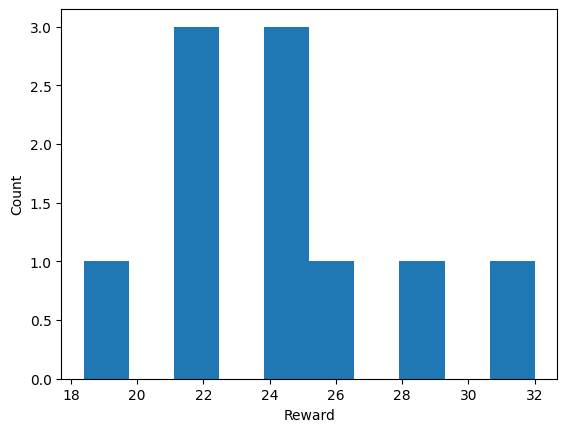

In [7]:
plot_reward_dist(env)

## Plot complexity, loss, and reward trend ##

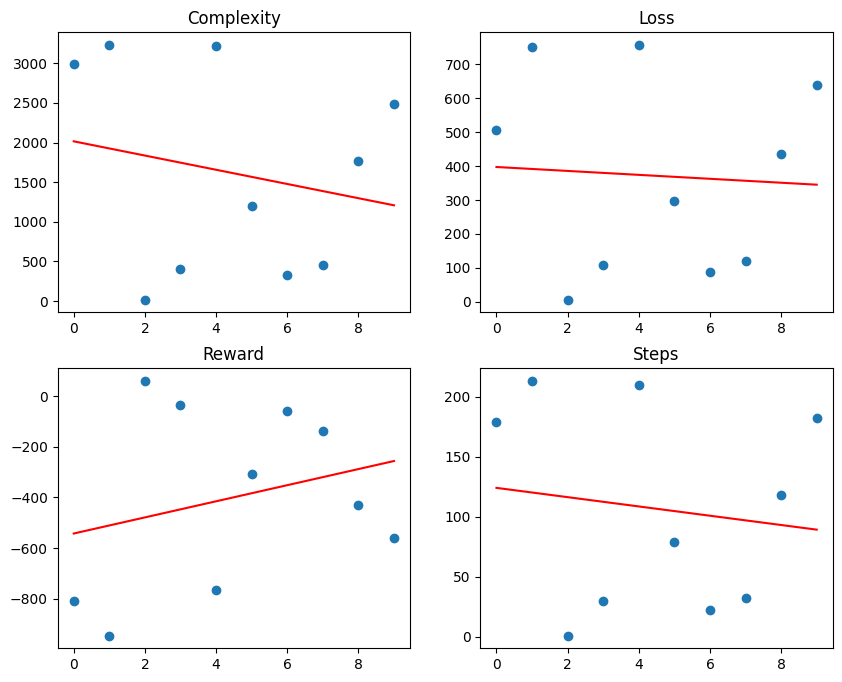

In [7]:
plot_trends(env)


## Run trained agent in eval mode ##

In [45]:
agent.update_config(config={'epsilon_threshold': 0.1})

INFO - 2023-04-21 07:54:30,374 [base.py:74] : Initialized Agent with config: {'batch_size': 64, 'gamma': 0.9, 'eps_start': 0.9, 'eps_end': 0.05, 'eps_decay_steps': 1000, 'eps_decay': None, 'epsilon_threshold': 0.1, 'tau': 1, 'learning_rate': 0.0003, 'hidden_size': 64, 'memory_cap': 10000, 'fill_memory_steps': 100, 'reset_steps': 100, 'state_dim': 128, 'feature_num': 100, 'grad_clip': 100, 'reward_function': 'diff_loss_reward', 'max_solution_steps': 10000}


In [30]:
G = agent.convert_state(parse_expr('-a1'))

In [31]:
action = agent.choose_optimal_action(G)
print(action)

tensor([[1]], device='cuda:0')


In [39]:
env.state_string = parse_expr('-a1')

In [40]:
env.state_string

-a1

In [42]:
env.actions[action]

[<function _operator.add(a, b, /)>, a1]

In [41]:
env.step(action)

(array([-8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       dtype=float32),
 14.0,
 False,
 {'ep': 1,
  'step': 50,
  'loop_step': 50,
  'complexity': 1,
  'loss': nan,
  'reward': 14.0,
  'state': 0,
  'approx': a1,
  'reset_step': False})

In [29]:
env.state_string

-a1

In [17]:
env.actions[action]

[<function _operator.sub(a, b, /)>, a1]

In [22]:
out = env.get_next_state(action)

In [21]:
env.next_state_string

0

In [23]:
out

0 - a1

In [37]:
agent.policy_network(agent.convert_state(parse_expr('-a1')))

tensor([[-1.1721,  1.2956, -1.8307,  0.1561,  0.7794,  0.4441,  0.9351, -1.3498,
          0.8282, -1.4291,  0.6185]], device='cuda:0', grad_fn=<MmBackward0>)

In [6]:
env.feature_dict

{'Add': -2,
 'Mul': -3,
 'Pow': -4,
 'x': -5,
 'a0': -6,
 'a1': -7,
 '0': -8,
 '1': -9,
 'I': -10}

In [50]:
out

(array([-11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.], dtype=float32),
 -8,
 False,
 {'ep': 10,
  'step': 2342,
  'loop_step': 1601,
  'complexity': 9,
  'loss': tensor(4.5076, device='cuda:

In [51]:
env.next_state_string

1

In [33]:
env.actions

[[<function _operator.add(a, b, /)>, a0],
 [<function _operator.add(a, b, /)>, a1],
 [<function _operator.add(a, b, /)>, 1],
 [<function _operator.sub(a, b, /)>, a0],
 [<function _operator.sub(a, b, /)>, a1],
 [<function _operator.sub(a, b, /)>, 1],
 [<function _operator.truediv(a, b, /)>, a0],
 [<function _operator.truediv(a, b, /)>, a1],
 [<function _operator.truediv(a, b, /)>, 1],
 [<function _operator.pow(a, b, /)>, a0],
 [<function _operator.pow(a, b, /)>, a1]]

In [39]:
agent.policy_network(G).max(1)[1].view(1,1)

tensor([[6]], device='cuda:0')

In [9]:
agent.train(10, eval=True)

INFO - 2023-04-21 07:32:28,750 [base.py:214] : Running training routine for 10 episodes in eval=True mode.


{'ep': '10  ', 'step': '2338', 'loop_step': '1597', 'complexity': '5.00e+00', 'loss': '4.51e+00', 'reward': '4.00e+00', 'state': '0                   '}: : 0it [03:05, ?it/s] 

KeyboardInterrupt: 

In [18]:
history = env.best_history
best_i = np.argmax(history['reward'])
print(parse_expr(str(history['state'][best_i])))
print(history['reward'][best_i])

-a1/a0
117.0


## Plot reward distribution for trained agent ##

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

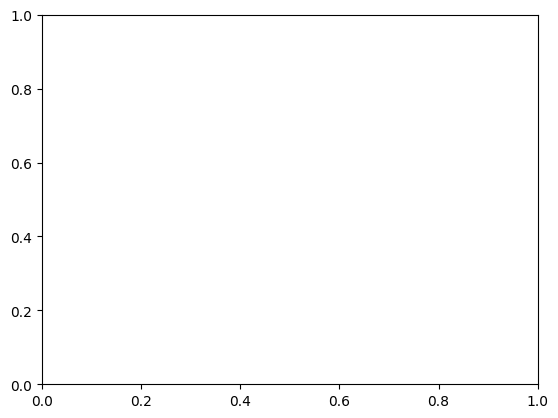

In [22]:
plot_reward_dist(env)

## Render final state graph ##

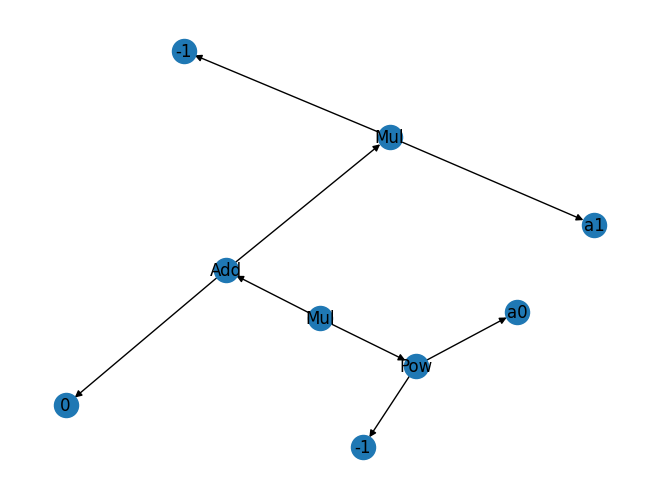

In [20]:
nx.draw(env.state_graph, labels=env.node_labels)

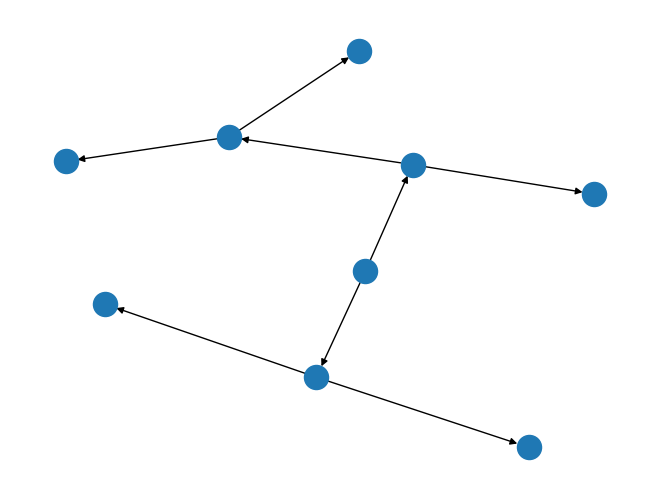

In [25]:
nx.draw(utilities.to_graph(env.history[9]['state'][-1], env.feature_dict))

## Run new Agent in eval mode ##

In [150]:
env = Env(order=2)
agent = AgentGCN(env, device='cuda:0')
agent.train(30, eval=True)

INFO - 2023-04-17 13:10:35,160 [algebraic.py:112] : Initializing environment with order=2, |S| = 11 x 64 = 704
INFO - 2023-04-17 13:10:35,163 [gcn.py:37] : Initialized Agent with device cuda:0
INFO - 2023-04-17 13:10:35,169 [base.py:298] : Running training routine for 30 episodes in eval=True mode.
INFO - 2023-04-17 13:10:35,194 [history.py:76] : 
{'ep': 0, 'step': 1, 'complexity': 14.0, 'loss': 'nan', 'reward': '-8.000e+00', 'state': 1/a1, 'approx': a0/a1 + a1}
INFO - 2023-04-17 13:10:35,196 [base.py:347] : 
Solver terminated after 3 steps: total_reward = -1.700e+01, mean_loss = nan, state = 1/a1
INFO - 2023-04-17 13:10:35,306 [history.py:76] : 
{'ep': 1, 'step': 8, 'complexity': 18.0, 'loss': 'nan', 'reward': '-4.000e+00', 'state': a0 - a1, 'approx': a0*(a0 - a1) + a1}
INFO - 2023-04-17 13:10:35,309 [base.py:347] : 
Solver terminated after 8 steps: total_reward = -1.700e+01, mean_loss = nan, state = a0 - a1
INFO - 2023-04-17 13:10:35,344 [history.py:76] : 
{'ep': 2, 'step': 11, 'comp

## Plot reward distribution for untrained agent ##

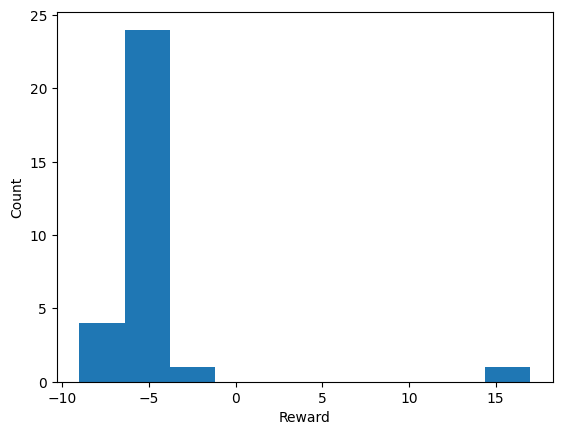

In [151]:
plot_reward_dist(env)